# VAE for Flowers102 dataset

In [3]:
# import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import mnist from pytorch
import torch
import torchvision
import torchvision.transforms as transforms

# import Flowers102 dataset
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

dataset = datasets.Flowers102(root='data', download=True, transform=transforms.ToTensor())

0.0%

100.0%


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100.0%


100.0%

In [4]:
# rescale dataset to grey scale and 500x500
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

dataset = datasets.Flowers102(root='data', download=True, transform=transform)

In [36]:
# get some info from the dataset, as number of images from each category
print(dataset)

Dataset Flowers102
    Number of datapoints: 1020
    Root location: data
    split=train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [16]:
# define a subset only images with label 0 and 1
subset = torch.utils.data.Subset(dataset, [i for i in range(len(dataset)) if dataset[i][1] in [0, 1]])

# create a dataloader
batch_size = 10
dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True)

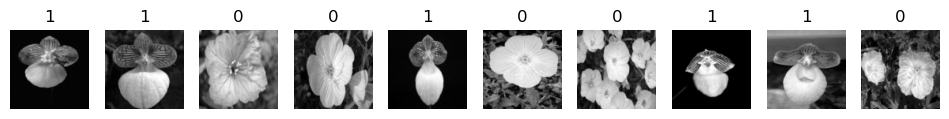

In [17]:
# show the images from the first batch with their labels
for images, labels in dataloader:
    fig, ax = plt.subplots(1, len(images), figsize=(12, 12))
    for i, image in enumerate(images):
        ax[i].imshow(image[0], cmap='gray')
        ax[i].set_title(labels[i].item())
        ax[i].axis('off')
    break


In [18]:
# print the shape of the first batch
print(images.shape)

torch.Size([10, 1, 100, 100])


In [32]:
# get some info from dataloader
print('Number of batches: ', len(dataloader))
print('Number of samples in the first batch: ', len(images))

Number of batches:  2
Number of samples in the first batch:  10


In [19]:
# define the model
# this is a VAE model
# for the encoder, two Conv2d layers are used to extract features from the input image
# the output image is of size 1x100x100
# first have 32 filters and kernel size 4, stride 2, padding 1
# second have 64 filters and kernel size 4, stride 2, padding 1
# then the output is flattened 
# the latent space is represented by two vectors, mean and logvar, dimension 2

# for the decoder, the latent space is first passed through a linear layer to get a tensor of size 64
# then reshaped to a tensor of size 64x1x1
# then passed through two ConvTranspose2d layers to get the output image
# first have 64 filters and kernel size 4, stride 2, padding 1
# second have 32 filters and kernel size 4, stride 2, padding 1
# the output image is of size 1x100x100

class VAE(torch.nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Flatten()
        )
        self.fc1 = torch.nn.Linear(64*25*25, latent_dim)
        self.fc2 = torch.nn.Linear(64*25*25, latent_dim)
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 64*25*25),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (64, 25, 25)),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            torch.nn.Sigmoid()
        )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc1(x)
        logvar = self.fc2(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [20]:
# define the model
latent_dim = 2  
model = VAE(latent_dim)

# define the loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [21]:
# test the model
reconst, mu, logvar = model(images)

In [28]:
# train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (images, _) in enumerate(dataloader):
        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)
        loss = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss {train_loss/len(dataloader.dataset)}')

Epoch 0, Loss 5161.1494140625
Epoch 1, Loss 5163.2029296875
Epoch 2, Loss 5148.42265625
Epoch 3, Loss 5148.7677734375
Epoch 4, Loss 5143.0865234375
Epoch 5, Loss 5136.505078125
Epoch 6, Loss 5134.637890625
Epoch 7, Loss 5131.440234375
Epoch 8, Loss 5129.62734375
Epoch 9, Loss 5126.1873046875
Epoch 10, Loss 5124.6794921875
Epoch 11, Loss 5123.5517578125
Epoch 12, Loss 5119.1203125
Epoch 13, Loss 5119.8755859375
Epoch 14, Loss 5119.2798828125
Epoch 15, Loss 5113.290625
Epoch 16, Loss 5111.4802734375
Epoch 17, Loss 5110.6931640625
Epoch 18, Loss 5107.74375
Epoch 19, Loss 5104.7826171875
Epoch 20, Loss 5104.265234375
Epoch 21, Loss 5102.64921875
Epoch 22, Loss 5102.1771484375
Epoch 23, Loss 5100.0548828125
Epoch 24, Loss 5095.15703125
Epoch 25, Loss 5091.7546875
Epoch 26, Loss 5091.296875
Epoch 27, Loss 5091.427734375
Epoch 28, Loss 5089.825390625
Epoch 29, Loss 5088.1943359375
Epoch 30, Loss 5087.1064453125
Epoch 31, Loss 5088.666796875
Epoch 32, Loss 5089.71953125
Epoch 33, Loss 5084.761

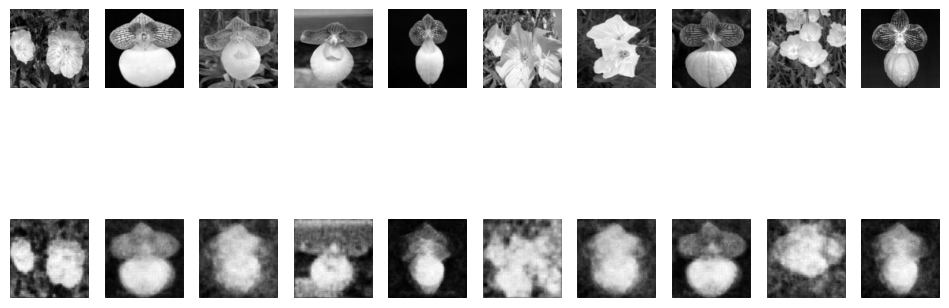

In [29]:
# show original and reconstructed images from first batch
for images, labels in dataloader:
    model.eval()
    reconst, _, _ = model(images)
    fig, ax = plt.subplots(2, len(images), figsize=(12, 5))
    for i, image in enumerate(images):
        ax[0, i].imshow(image[0], cmap='gray')
        ax[0, i].axis('off')
    for i, image in enumerate(reconst):
        ax[1, i].imshow(image[0].detach(), cmap='gray')
        ax[1, i].axis('off')
    break

In [30]:
# plot the latent space of the train set

model.eval()
latent_vectors = []
categories = [] 

for images, labels in dataloader:
    _, mu, _ = model(images)
    latent_vectors.append(mu.detach().numpy())
    categories.append(labels.detach().numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
categories = np.concatenate(categories, axis=0)

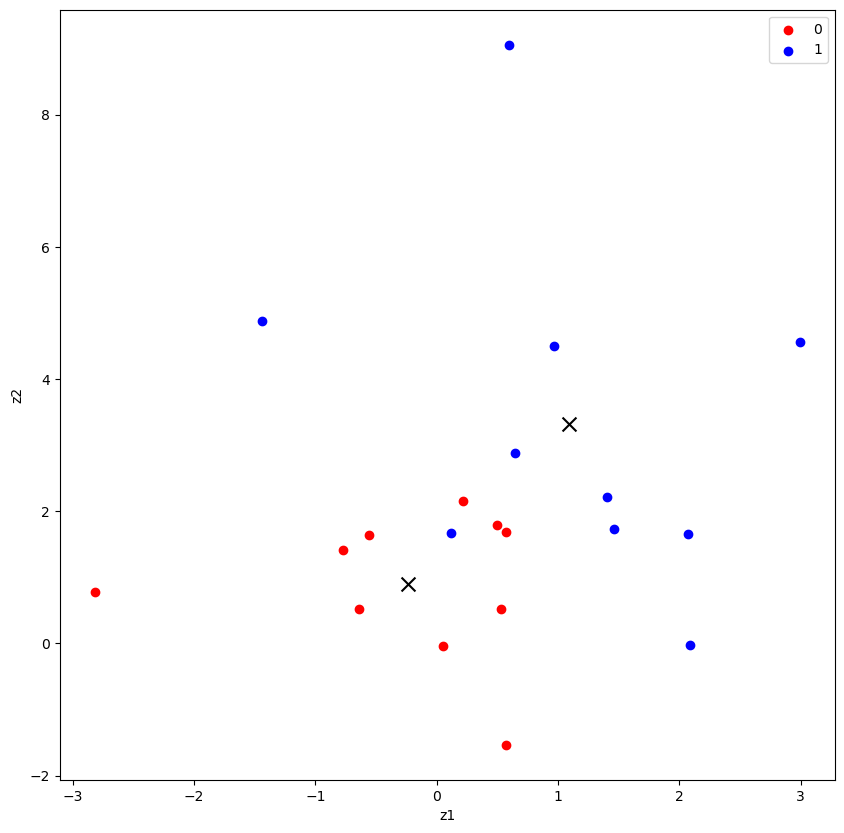

In [31]:
plt.figure(figsize=(10, 10))
plt.scatter(latent_vectors[categories==0, 0], latent_vectors[categories==0, 1], label='0', color='red')
plt.scatter(latent_vectors[categories==1, 0], latent_vectors[categories==1, 1], label='1', color='blue')

# get the mean on 1 and 9
mean_0 = np.mean(latent_vectors[categories==0], axis=0)
mean_1 = np.mean(latent_vectors[categories==1], axis=0)

plt.scatter(mean_0[0], mean_0[1], color='black', marker='x', s=100)
plt.scatter(mean_1[0], mean_1[1], color='black', marker='x', s=100)

# add labels
plt.xlabel('z1')
plt.ylabel('z2')

# add legend
plt.legend()
